In [63]:
import gctree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
from matplotlib.ticker import MaxNLocator

## Load trees from results directory

In [64]:
results = "../nextflow/results/latest"

In [65]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 95 GC trees


In [66]:
# mmodel = gctree.mutation_model.MutationModel(mutability_file="../nextflow/data/mutability/MK_RS5NF_mutability.csv", substitution_file="../nextflow/data/mutability/MK_RS5NF_substitution.csv")
# mutability_edge_weight_func = gctree.mutation_model._mutability_distance(mmodel)

## Data frame with a row for each node on each tree, excluding 10-week mice, and LMP mice

REI decay factor

In [67]:
tau = 0.5

In [68]:
rows = []
for gc, tree in trees.items():    
    # hack: tree with all dist = 1, to get edge count distances between nodes
    tree_topo = tree.tree.copy(method="deepcopy")
    for node in tree_topo.traverse():
        if not node.is_root():
            node.dist = 1
        
    total_abundance = sum(node.abundance for node in tree.tree.traverse())

    for node, node_topo in zip(tree.tree.traverse(), tree_topo.traverse()):
            assert node.name == node_topo.name
        
            root_distance_nt = node.get_distance(tree.tree)
            root_distance_topo = node_topo.get_distance(tree_topo)

            descendant_distances_nt = [node.get_distance(descendant)
                                       for descendant in node.traverse()
                                       if descendant.abundance]
            descendant_distances_topo = [node_topo.get_distance(descendant)
                                         for descendant in node_topo.traverse()
                                         if descendant.abundance]
            
            assert all(x >= y for x, y in zip(descendant_distances_nt, descendant_distances_topo))
            
            closest_leaf_distance_nt = min(descendant_distances_nt)
            closest_leaf_distance_topo = min(descendant_distances_topo)
            farthest_leaf_distance_nt = max(descendant_distances_nt)
            farthest_leaf_distance_topo = max(descendant_distances_topo)
            
            node.REI = sum(node2.abundance * tau ** node2.get_distance(node) for node2 in node.traverse()) / total_abundance

            if farthest_leaf_distance_topo == 0:
                assert farthest_leaf_distance_nt == 0, (gc, node.name, len(node.children), farthest_leaf_distance_nt)
            
            # if node.up is not None:                
            #     mutability_change = (sum(mutability[0]
            #                              for mutability in mmodel.mutabilities(node.sequence))
            #                          - sum(mutability[0]
            #                                for mutability in mmodel.mutabilities(node.up.sequence)))
            # else:
            #     mutability_change = np.nan
            
            branch_length = sum(node.dist for node in tree.tree.traverse())

            # compare nodes (e.g. bursts) with their sisters
            if node.up is not None and len(node.up.children) > 1:
                mean_sister_delta_bind_CGG_naive = np.mean([node2.delta_bind_CGG_FVS_additive
                                                for node2 in node.up.children
                                                if node2.name != node.name])
            else:
                mean_sister_delta_bind_CGG_naive = np.nan
            
            rows.append([gc,
                         node.name,
                         node.up.name if node.up else np.nan,
                         ";".join(node.mutations),
                         ";".join(set(node.mutations) - (set(node.up.mutations) if node.up is not None else set())),
                         ";".join((set(node.up.mutations) if node.up is not None else set()) - set(node.mutations)),
                         node.abundance,
                         len(node.children),
                         node.abundance + len(node.children),
                         node.LBI,
                         node.LBR,
                         node.REI,
                         sum(node.LB_down.values()) / branch_length,
                         root_distance_nt,
                         root_distance_topo,
                         closest_leaf_distance_nt,
                         closest_leaf_distance_topo,
                         farthest_leaf_distance_nt,
                         farthest_leaf_distance_topo,
                         node.delta_bind_CGG_FVS_additive,
                         node.up.delta_bind_CGG_FVS_additive if node.up else np.nan,
                         node.delta_bind_CGG_FVS_additive - node.up.delta_bind_CGG_FVS_additive if node.up is not None else np.nan,
                         node.delta_expr_FVS_additive,
                         node.delta_psr_FVS_additive,
                         mean_sister_delta_bind_CGG_naive,
                         # mutability_change
                        ])

df = pd.DataFrame(rows, columns=["GC",
                                 "name",
                                 "parent_name",
                                 "aa_mutations",
                                 "aa_mutations_edge_gained",
                                 "aa_mutations_edge_lost",
                                 "abundance",
                                 "n_mutant_edges",
                                 "polytomy_degree",
                                 "LBI",
                                 "LBR",
                                 "REI",
                                 "LBF",
                                 "root_distance_nt",
                                 "root_distance_topo",
                                 "closest_leaf_distance_nt",
                                 "closest_leaf_distance_topo",
                                 "farthest_leaf_distance_nt",
                                 "farthest_leaf_distance_topo",
                                 "delta_bind_CGG_naive",
                                 "parent_delta_bind_CGG_naive",
                                 "delta_bind_CGG_edge",
                                 "delta_expr",
                                 "delta_psr",
                                 "mean_sister_delta_bind_CGG_naive",
                                 # "mutability_change",
                                ])

# only 20-day mice
df = df.loc[df.GC.str.split("_").explode()[::2].isin([f"mouse{i}" for i in range(1, 7)])]

df

,GC,name,parent_name,aa_mutations,aa_mutations_edge_gained,aa_mutations_edge_lost,abundance,n_mutant_edges,polytomy_degree,LBI,...,closest_leaf_distance_nt,closest_leaf_distance_topo,farthest_leaf_distance_nt,farthest_leaf_distance_topo,delta_bind_CGG_naive,parent_delta_bind_CGG_naive,delta_bind_CGG_edge,delta_expr,delta_psr,mean_sister_delta_bind_CGG_naive
0,mouse1_GC1,naive,NaN,,,,0,5,5,11.383587,...,1.0,1.0,12.0,6.0,0.00000,NaN,NaN,0.00000,0.00000,NaN
1,mouse1_GC1,seq62,naive,Y103(H)F;S20(L)N;L116(L)P,S20(L)N;Y103(H)F;L116(L)P,,1,0,1,1.172202,...,0.0,0.0,0.0,0.0,-0.06082,0.00000,-0.06082,0.14827,-0.13364,-2.911095
2,mouse1_GC1,seq9,naive,E51(H)G;Y52(H)F;Y66(L)N;V71(L)I;D74(L)A;Q95(L)...,Y66(L)N;Q95(L)E;V71(L)I;E51(H)G;D74(L)A;S96(L)...,,1,0,1,1.000157,...,0.0,0.0,0.0,0.0,-3.45668,0.00000,-3.45668,-1.05627,3.34321,-2.062130
3,mouse1_GC1,seq76,naive,Y58(H)D,Y58(H)D,,1,1,2,5.881581,...,0.0,0.0,2.0,1.0,-0.80796,0.00000,-0.80796,-0.15104,-0.15010,-2.724310
4,mouse1_GC1,1,naive,N40(H)H;N108(L)D;Y114(L)S;E125(L)Q,N108(L)D;Y114(L)S;N40(H)H;E125(L)Q,,0,2,2,3.115025,...,3.0,1.0,5.0,1.0,-7.71074,0.00000,-7.71074,-0.77924,2.61806,-0.998615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5586,mouse6_GC77,seq45,2,K49(H)I;G54(H)V;S70(H)A;K72(H)R;S74(H)G;I78(H)...,Y88(H)S,,1,0,1,1.363245,...,0.0,0.0,0.0,0.0,-0.00473,0.01741,-0.02214,-1.97716,4.12977,0.014770
5587,mouse6_GC77,seq19,12,S57(H)N;S64(H)R;T65(H)I;Y103(H)F;A105(H)G,Y103(H)F,,1,0,1,1.072084,...,0.0,0.0,0.0,0.0,1.23641,1.19398,0.04243,-0.08653,0.23259,0.542210
5588,mouse6_GC77,seq17,12,S57(H)N;S64(H)R;T65(H)I;A105(H)G;M11(L)L;G36(L...,G36(L)V;K123(L)N;Y66(L)S;M11(L)L,,2,0,2,2.273950,...,0.0,0.0,0.0,0.0,-0.00518,1.19398,-1.19916,-0.31626,-0.55349,1.163005
5589,mouse6_GC77,seq9,12,S57(H)N;S64(H)R;T65(H)I;L89(H)V;A105(H)G,L89(H)V,,3,1,4,4.030638,...,0.0,0.0,1.0,1.0,1.08960,1.19398,-0.10438,-0.12466,-0.23740,0.615615


In [69]:
# NOTE: remove affinity effect of A105(H))G mutation!!!!!
# df.loc[df.aa_mutations.str.contains("A105(H)G", regex=False), "delta_bind_CGG_naive"] -= 0.331
# df.loc[df.aa_mutations_edge_gained.str.contains("A105(H)G", regex=False), "delta_bind_CGG_edge"] -= 0.331

In [70]:
# check that names are unique
df.groupby(["GC", "name"]).size().unique()

array([1])

In [71]:
output_dir = "output/fitness-regression"

In [72]:
df.to_csv(f"{output_dir}/data.csv", index=False)

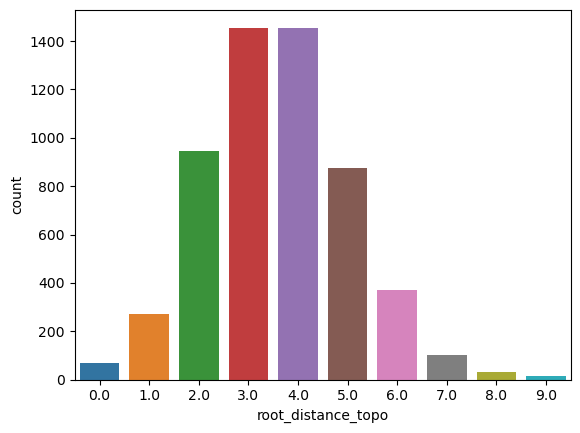

In [73]:
sns.countplot(data=df, x="root_distance_topo")
plt.show()

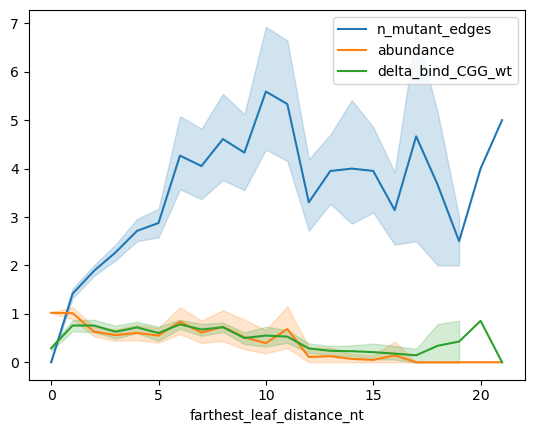

In [74]:
sns.lineplot(data=df, x="farthest_leaf_distance_nt", y="n_mutant_edges", label="n_mutant_edges")
sns.lineplot(data=df, x="farthest_leaf_distance_nt", y="abundance", label="abundance")
sns.lineplot(data=df, x="farthest_leaf_distance_nt", y="delta_bind_CGG_naive", label="delta_bind_CGG_wt")
# sns.lineplot(data=df, x="farthest_leaf_distance_nt", y="polytomy_degree", label="polytomy_degree")
plt.ylabel("")
plt.show()

<Axes: xlabel='farthest_leaf_distance_nt', ylabel='REI'>

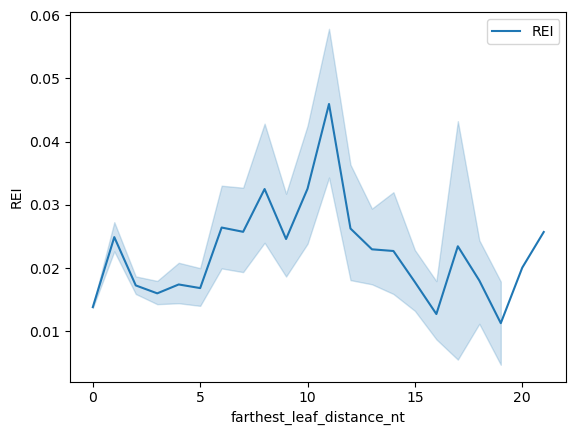

In [75]:
sns.lineplot(data=df, x="farthest_leaf_distance_nt", y="REI", label="REI")

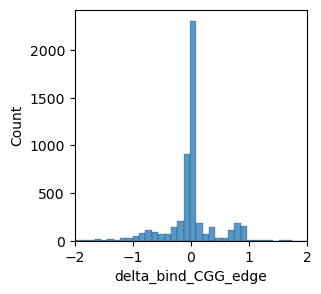

In [76]:
plt.figure(figsize=(3, 3))
sns.histplot(data=df, x="delta_bind_CGG_edge", bins=120)
plt.xlim(-2, 2)
plt.show()

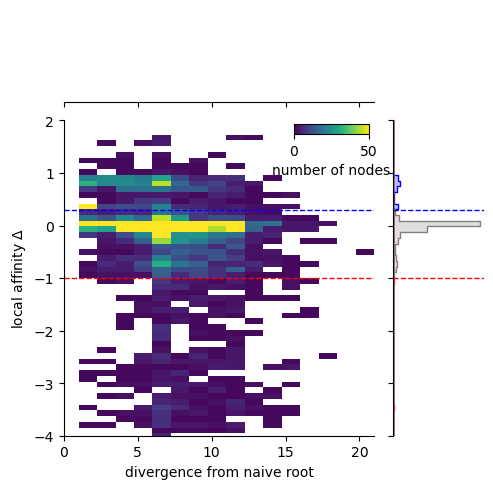

In [77]:
gain_thresh = 0.3
loss_thresh = -1

# absolute affinity strata
df.loc[~df.delta_bind_CGG_naive.isna(), "affinity stratum"] = "affinity neutral"
df.loc[df["delta_bind_CGG_naive"] > gain_thresh, "affinity stratum"] = "affinity gain"
df.loc[df["delta_bind_CGG_naive"] < loss_thresh, "affinity stratum"] = "affinity loss"

# affinity change strata
df.loc[~df.delta_bind_CGG_edge.isna(), "affinity change stratum"] = "affinity neutral"
df.loc[df["delta_bind_CGG_edge"] > gain_thresh, "affinity change stratum"] = "affinity gain"
df.loc[df["delta_bind_CGG_edge"] < loss_thresh, "affinity change stratum"] = "affinity loss"
palette = {"affinity loss": "red", "affinity neutral": "grey", "affinity gain": "blue"}


g = sns.JointGrid(data=df,
                  x="root_distance_nt",
                  # x="farthest_leaf_distance_nt",
                #   y="delta_bind_CGG_naive",
                  y="delta_bind_CGG_edge",
                  xlim=(0, df.root_distance_nt.max()),
                  ylim=(-4, 2),
                  height=5, ratio=3)
g = g.plot_joint(sns.histplot,
                 bins=(16, 120),
                 vmax=50,
                 cmap="viridis",
                 cbar=True,                 
                 cbar_ax=plt.gcf().add_axes([0.59, 0.72, 0.15, 0.02]),
                 cbar_kws=dict(orientation='horizontal', label="number of nodes"),
                )
sns.histplot(ax=g.ax_marg_y,
            #  y=df["delta_bind_CGG_naive"],
            #  hue=df["affinity stratum"],
             y=df["delta_bind_CGG_edge"],
             hue=df["affinity change stratum"],
             bins=120,
             palette=palette,
             fill=True, element="step", linewidth=1,
             legend=False)
g.ax_marg_y.axhline(gain_thresh, c="blue", ls="--", lw=1)
g.ax_marg_y.axhline(loss_thresh, c="red", ls="--", lw=1)
g.ax_joint.axhline(gain_thresh, c="blue", ls="--", lw=1)
g.ax_joint.axhline(loss_thresh, c="red", ls="--", lw=1)
g.set_axis_labels(
    "divergence from naive root",
    # "distance from farthest leaf",
    # r"affinity $\Delta$",
    r"local affinity $\Delta$",
    )
plt.savefig(f"{output_dir}/heatmap.pdf")
plt.show()


# g = sns.JointGrid(data=df, x="root_distance_nt", y="LBR",
#                   xlim=(0, df.root_distance_nt.max()),
#                   height=5, ratio=3)
# g = g.plot_joint(sns.histplot,
#                  bins=(16, 15),
#                  vmax=50,
#                  cmap="viridis",
#                  log_scale=(False, False))
# sns.histplot(ax=g.ax_marg_y,
#              y=df.LBR, hue=df["affinity change stratum"],
#              log_scale=False,
#              bins=15,
#              stat="probability", common_norm=False,
#              palette=palette,
#              fill=False, element="step", linewidth=1,
#              legend=False)
# g.set_axis_labels("divergence from naive root", "LBR")
# plt.show()

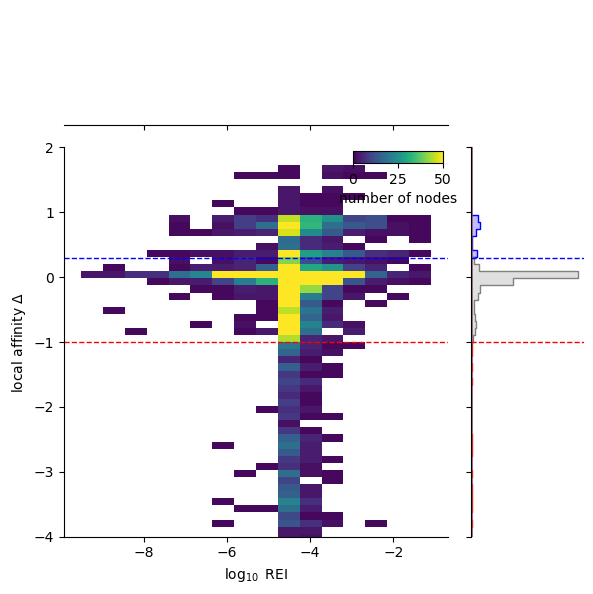

In [78]:
gain_thresh = 0.3
loss_thresh = -1
df.loc[~df.delta_bind_CGG_edge.isna(), "affinity change stratum"] = "affinity neutral"
df.loc[df["delta_bind_CGG_edge"] > gain_thresh, "affinity change stratum"] = "affinity gain"
df.loc[df["delta_bind_CGG_edge"] < loss_thresh, "affinity change stratum"] = "affinity loss"
palette = {"affinity loss": "red", "affinity neutral": "grey", "affinity gain": "blue"}


g = sns.JointGrid(data=df, x=np.log(df.REI),
                  y="delta_bind_CGG_edge",
                #   xlim=(0, np.log(df.REI.max())),
                  ylim=(-4, 2),
                  height=6, ratio=3)
g = g.plot_joint(sns.histplot,
                 bins=(16, 120),
                 vmax=50,
                 cmap="viridis",
                 cbar=True,                 
                 cbar_ax=plt.gcf().add_axes([0.59, 0.72, 0.15, 0.02]),
                 cbar_kws=dict(orientation='horizontal', label="number of nodes"),
                )
sns.histplot(ax=g.ax_marg_y,
             y=df["delta_bind_CGG_edge"], hue=df["affinity change stratum"],
             bins=120,
             palette=palette,
             fill=True, element="step", linewidth=1,
             legend=False)
g.ax_marg_y.axhline(gain_thresh, c="blue", ls="--", lw=1)
g.ax_marg_y.axhline(loss_thresh, c="red", ls="--", lw=1)
g.ax_joint.axhline(gain_thresh, c="blue", ls="--", lw=1)
g.ax_joint.axhline(loss_thresh, c="red", ls="--", lw=1)
g.set_axis_labels(r"$\log_{10}$ REI", r"local affinity $\Delta$")
plt.savefig(f"{output_dir}/heatmap2.pdf")
plt.show()

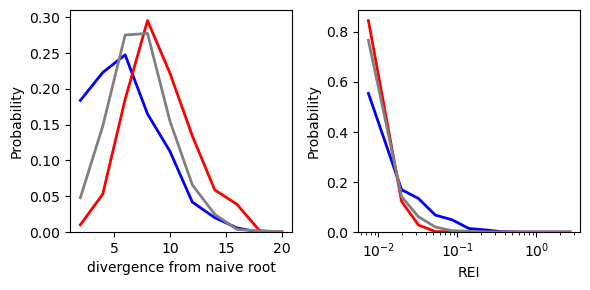

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


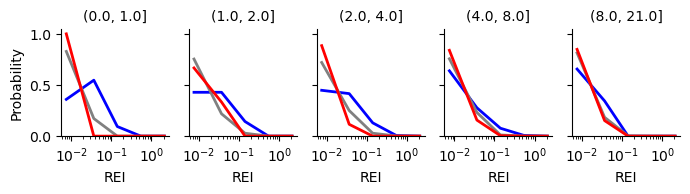

In [79]:
df["divergence stratum"] = pd.cut(df.root_distance_nt, [0, 1, 2, 4, 8, df.root_distance_nt.max()])
df["leaf distance stratum"] = pd.cut(df.farthest_leaf_distance_nt, [0, 2, 5, 10, df.farthest_leaf_distance_nt.max()])

# branching_stat = "LBI"
# branching_stat = "LBR"
branching_stat = "REI"

linthresh = 0.015
bins1 = [0] + list(np.logspace(np.log10(linthresh), np.log10(df[branching_stat].max()) + 1, 12))
bins2 = [0] + list(np.logspace(np.log10(linthresh), np.log10(df[branching_stat].max()) + 1, 5))

plt.figure(figsize=(6, 3))

plt.subplot(121)
sns.histplot(data=df,
             x="root_distance_nt",
            #  x="farthest_leaf_distance_nt",
            #  hue="affinity stratum",
             hue="affinity change stratum",
             bins=10,
             stat="probability", common_norm=False,
             palette=palette,
             fill=False, element="poly", linewidth=2,
             legend=False)
plt.xlabel("divergence from naive root")
# plt.xlabel("distance from farthest leaf")
# plt.xscale("log")
# plt.yscale("log")

plt.subplot(122)
sns.histplot(data=df, x=branching_stat,
            #  hue="affinity stratum",
             hue="affinity change stratum",
             bins=bins1,
             stat="probability", common_norm=False,
             palette=palette,
             fill=False, element="poly", linewidth=2,
             legend=False)
plt.xlabel(branching_stat)
plt.xscale("log")
# plt.yscale("log")
# plt.xscale("symlog", linthresh=linthresh)
# plt.xlim(0, None)
plt.tight_layout()
plt.savefig(f"{output_dir}/divergence-{branching_stat}.pdf")
plt.show()

g = sns.displot(data=df,
            col="divergence stratum",
            # col="leaf distance stratum",
            x=branching_stat,
            # hue="affinity stratum",
            hue="affinity change stratum",
            hue_order=palette.keys(),
            palette=palette,
            bins=bins2,
            stat="probability",
            common_norm=False,
            aspect=0.7, height=2,
            fill=False, element="poly", linewidth=2,
            legend=False
           )
g.set_titles(col_template="{col_name}")
plt.xscale("log")
# plt.yscale("log")
# plt.xscale("symlog", linthresh=linthresh)
# plt.xlim(0, None)
plt.savefig(f"{output_dir}/divergence-stratified-{branching_stat}.pdf")
plt.show()

In [80]:
df.query("`affinity stratum` == 'affinity gain' & 0.095 < REI < 0.105")

,GC,name,parent_name,aa_mutations,aa_mutations_edge_gained,aa_mutations_edge_lost,abundance,n_mutant_edges,polytomy_degree,LBI,...,delta_bind_CGG_naive,parent_delta_bind_CGG_naive,delta_bind_CGG_edge,delta_expr,delta_psr,mean_sister_delta_bind_CGG_naive,affinity stratum,affinity change stratum,divergence stratum,leaf distance stratum
1971,mouse2_GC26,17,18,A105(H)G;N108(L)K,N108(L)K,,0,2,2,13.508528,...,1.19682,0.33100,0.86582,0.04020,0.15191,0.820087,affinity gain,affinity gain,"(1.0, 2.0]","(5.0, 10.0]"
3621,mouse3_GC59,seq31,9,S57(H)N;S64(H)R;A105(H)G,S57(H)N;S64(H)R,,3,8,11,9.808548,...,1.18730,0.33100,0.85630,-0.04328,-0.01930,0.379475,affinity gain,affinity gain,"(2.0, 4.0]","(2.0, 5.0]"
3880,mouse3_GC72,seq1,8,T65(H)S;T95(H)S;A105(H)G;G36(L)D;N108(L)K,A105(H)G;T95(H)S,,5,3,8,6.789899,...,0.48975,0.14779,0.34196,-0.14340,0.06986,0.380150,affinity gain,affinity gain,"(4.0, 8.0]","(0.0, 2.0]"
3901,mouse3_GC72,seq4,7,T65(H)S;G36(L)D;A52(L)S;N108(L)K,,,4,9,13,12.413929,...,0.85573,0.85573,0.00000,-0.17490,0.28702,-0.846740,affinity gain,affinity neutral,"(4.0, 8.0]","(5.0, 10.0]"
4005,mouse4_GC48,seq9,naive,T65(H)I;Y103(H)F;K51(L)R;A52(L)S,A52(L)S;T65(H)I;Y103(H)F;K51(L)R,,3,14,17,16.469630,...,0.77020,0.00000,0.77020,-0.13738,0.22880,-0.529905,affinity gain,affinity gain,"(4.0, 8.0]","(5.0, 10.0]"
4006,mouse4_GC48,seq42,naive,Y42(L)N;N108(L)H,Y42(L)N;N108(L)H,,2,15,17,18.535323,...,0.82596,0.00000,0.82596,-1.10723,0.62893,-0.539198,affinity gain,affinity gain,"(1.0, 2.0]","(2.0, 5.0]"
4454,mouse4_GC70,7,8,N92(H)K;Y42(L)C;N108(L)H,Y42(L)C,,0,2,2,11.438962,...,0.73112,0.74154,-0.01042,-0.38964,0.08942,-2.547000,affinity gain,affinity neutral,"(2.0, 4.0]","(5.0, 10.0]"


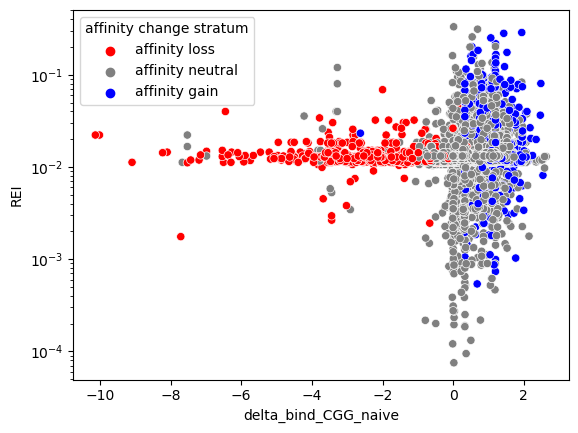

/opt/miniconda3/envs/replay/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


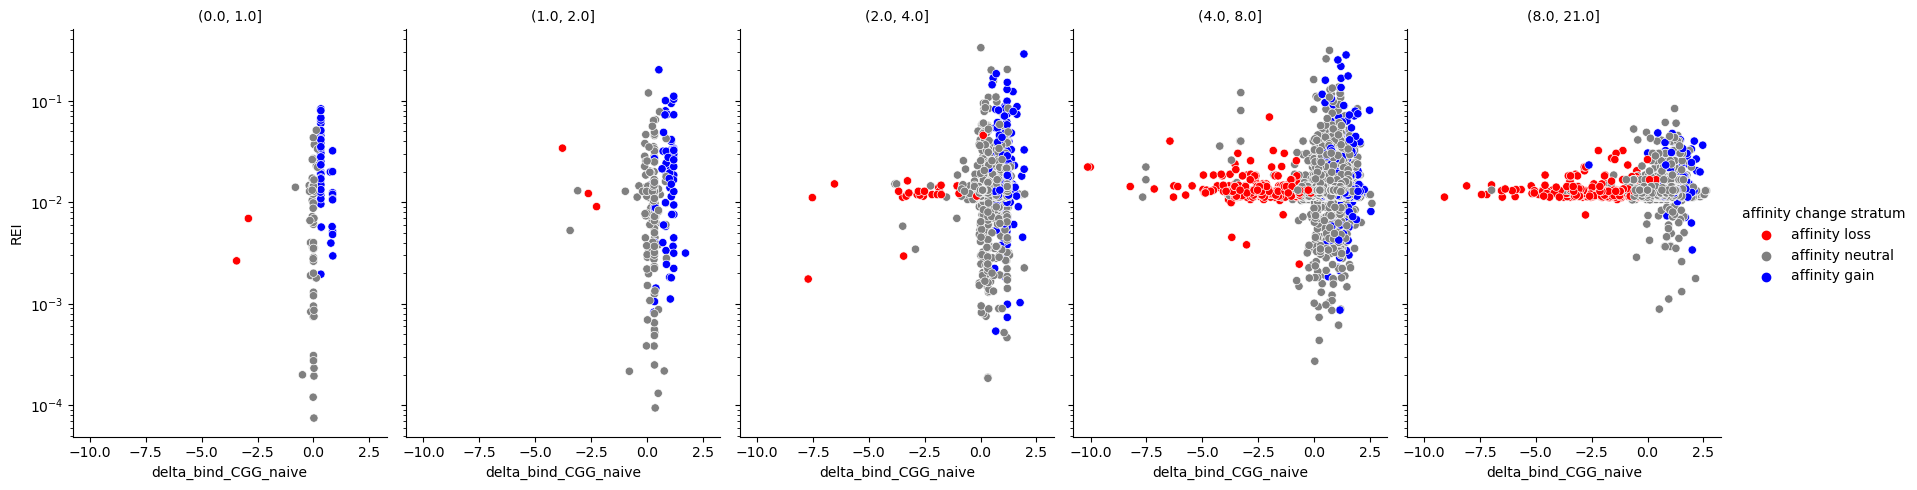

In [81]:
g = sns.scatterplot(data=df, x="delta_bind_CGG_naive", y="REI", hue="affinity change stratum",
                palette=palette, hue_order=palette.keys())
plt.yscale("log")
# g.set_xlabels("affinity")
plt.show()

g = sns.relplot(data=df, x="delta_bind_CGG_naive", y="REI", col="divergence stratum", hue="affinity change stratum",
                palette=palette, hue_order=palette.keys(),
           aspect=0.7, height=5,)
g.set_titles(col_template="{col_name}")
# g.axes[0,0].axvline(thresh)
plt.yscale("log")
# g.set_xlabels("affinity")
plt.show()

LBI: p=0.28
LBR: p=0.40
REI: p=0.10


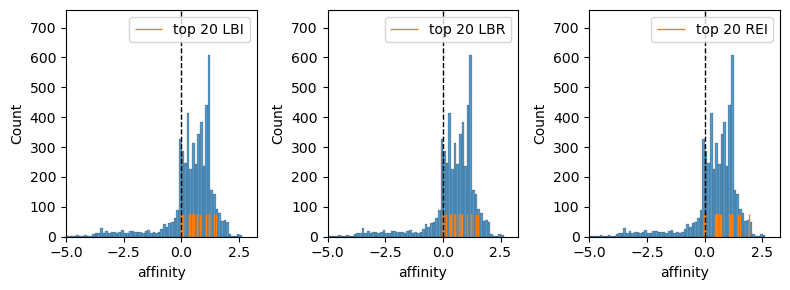

In [82]:
from scipy.stats import ttest_ind

top = 20

plt.figure(figsize=(8, 3))
plt.subplot(131)
sns.histplot(data=df, x="delta_bind_CGG_naive")
sns.rugplot(data=df.loc[df.sort_values("LBI", ascending=False).head(top).index], x="delta_bind_CGG_naive", color="C1", height=0.1, label=f"top {top} LBI", lw=2)
plt.axvline(0, c="k", ls="--", lw=1)
plt.xlabel("affinity")
plt.xlim(-5, None)
plt.legend()

print(f'LBI: p={ttest_ind(df.delta_bind_CGG_naive[df.sort_values("LBI", ascending=False).head(top).index], df.delta_bind_CGG_naive[~df.index.isin(df.sort_values("LBI", ascending=False).head(top).index)], nan_policy="omit").pvalue:.2f}')

plt.subplot(132)
sns.histplot(data=df, x="delta_bind_CGG_naive")
sns.rugplot(data=df.loc[df.sort_values("LBR", ascending=False).head(top).index], x="delta_bind_CGG_naive", color="C1", height=0.1, label=f"top {top} LBR", lw=2)
plt.axvline(0, c="k", ls="--", lw=1)
plt.xlabel("affinity")
plt.xlim(-5, None)
plt.legend()

print(f'LBR: p={ttest_ind(df.delta_bind_CGG_naive[df.sort_values("LBR", ascending=False).head(top).index], df.delta_bind_CGG_naive[~df.index.isin(df.sort_values("LBR", ascending=False).head(top).index)], nan_policy="omit").pvalue:.2f}')

plt.subplot(133)
sns.histplot(data=df, x="delta_bind_CGG_naive")
sns.rugplot(data=df.loc[df.sort_values("REI", ascending=False).head(top).index], x="delta_bind_CGG_naive", color="C1", height=0.1, label=f"top {top} REI", lw=2)
plt.axvline(0, c="k", ls="--", lw=1)
plt.xlabel("affinity")
plt.xlim(-5, None)
plt.legend()

print(f'REI: p={ttest_ind(df.delta_bind_CGG_naive[df.sort_values("REI", ascending=False).head(top).index], df.delta_bind_CGG_naive[~df.index.isin(df.sort_values("REI", ascending=False).head(top).index)], nan_policy="omit").pvalue:.2f}')

plt.tight_layout()

plt.savefig(f"{output_dir}/top10.pdf")
plt.show()


# g = sns.displot(data=df, x="delta_bind_CGG_naive", col="divergence stratum", hue="burst",
#                 alpha=1, hue_order=[True, False],
#            aspect=0.7, height=3,)
# g.set_titles(col_template="{col_name}")
# g.axes[0,0].axvline(0, c="k", ls="--", lw=1)
# g.axes[0,1].axvline(0, c="k", ls="--", lw=1)
# g.axes[0,2].axvline(0, c="k", ls="--", lw=1)
# g.axes[0,3].axvline(0, c="k", ls="--", lw=1)
# g.axes[0,4].axvline(0, c="k", ls="--", lw=1)
# g.set_xlabels("affinity")
# plt.xlim(-2, 2)
# plt.show()

### Comparison to sisters

For statistical independence, we can only take one node—the max REI node—from each tree

In [140]:
# max REI row per GC
df_max = df.loc[df.groupby("GC")["REI"].idxmax()]

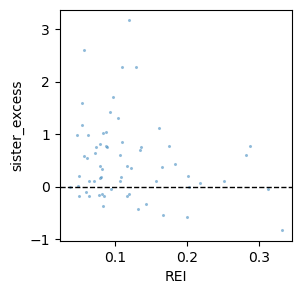

In [141]:
df_max["sister_excess"] = df_max.delta_bind_CGG_naive - df_max.mean_sister_delta_bind_CGG_naive

# plot of sister excess vs. REI
plt.figure(figsize=(3, 3))
sns.scatterplot(data=df_max,
                y="sister_excess", x="REI", s=5, alpha=0.5)
plt.axhline(0, c="k", ls="--", lw=1)
# plt.axhline(0.2, c="k", ls="--", lw=1)
# plt.axvline(0, c="k", ls="--", lw=1)
# plt.xlim(-2, 2)
# plt.ylim(-0.05, 0.25)
plt.show()

In [142]:
df_max.sort_values("delta_bind_CGG_naive")[["GC", "REI", "name", "delta_bind_CGG_naive"]]

,GC,REI,name,delta_bind_CGG_naive
2601,mouse2_GC39,0.120000,seq10,-3.27805
3532,mouse3_GC58,0.050164,seq29,-0.11017
3161,mouse3_GC46,0.048780,seq15,-0.04850
3436,mouse3_GC57,0.161347,seq1,-0.01738
5511,mouse6_GC77,0.068267,naive,0.00000
...,...,...,...,...
2268,mouse2_GC31,0.073438,seq10,1.62628
2731,mouse3_GC41,0.087355,seq4,1.63197
1763,mouse2_GC24,0.054003,seq31,1.67204
1518,mouse2_GC21,0.078827,seq24,1.83897


(-0.25, 1.25)

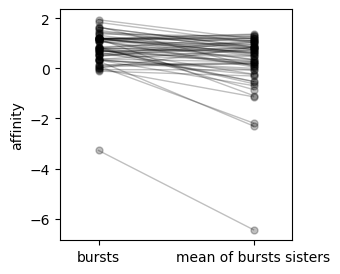

In [143]:
plt.figure(figsize=(3, 3))
plt.plot([[0, 1]] * len(df_max), df_max[["delta_bind_CGG_naive", "mean_sister_delta_bind_CGG_naive"]].values, "o", c="k", ms=5, alpha=0.25)
for i, (x, y) in enumerate(df_max[["delta_bind_CGG_naive", "mean_sister_delta_bind_CGG_naive"]].values):
    plt.plot([0, 1], [x, y], c="k", lw=1, alpha=0.25)
plt.xticks([0, 1], ["bursts", "mean of bursts sisters"])
plt.ylabel("affinity")
plt.xlim(-0.25, 1.25)

In [144]:
# two sample test
from scipy.stats import wilcoxon
df_max_nonan = df_max[["delta_bind_CGG_naive", "mean_sister_delta_bind_CGG_naive"]].dropna()
wilcoxon(df_max_nonan.delta_bind_CGG_naive, df_max_nonan.mean_sister_delta_bind_CGG_naive)

WilcoxonResult(statistic=332.0, pvalue=3.692739590165037e-06)

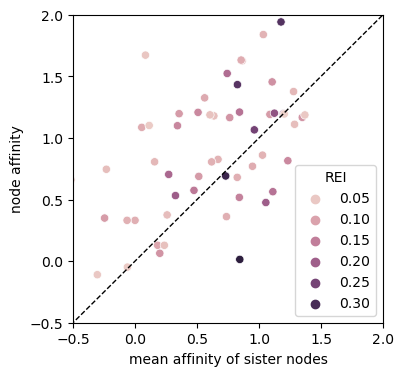

In [145]:
plt.figure(figsize=(4, 4))
sns.scatterplot(data=df_max, y="delta_bind_CGG_naive", x="mean_sister_delta_bind_CGG_naive", hue="REI")
plt.plot([-2, 2], [-2, 2], c="k", ls="--", lw=1)
plt.xlim(-0.5, 2)
plt.ylim(-0.5, 2)
plt.xlabel("mean affinity of sister nodes")
plt.ylabel("node affinity")
plt.show()

## Are terrible nodes usually leaves? 

Note: need to aggregate to a GC-level metric, so we can properly test

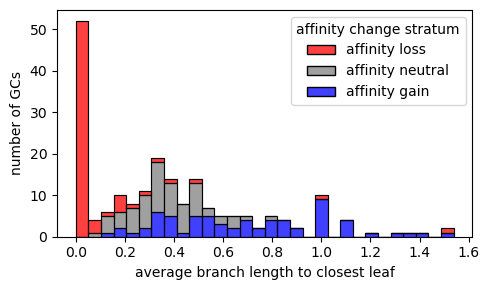

In [21]:
df_groups = df.groupby(["GC", "affinity change stratum"]).closest_leaf_distance_nt.mean().reset_index()

plt.figure(figsize=(5, 3))
sns.histplot(data=df_groups,
              hue="affinity change stratum", x="closest_leaf_distance_nt",
              hue_order=("affinity loss", "affinity neutral", "affinity gain"),
              multiple="stack",
              bins=30,
              palette=palette,
            #   size=5
              )
plt.xlabel("average branch length to closest leaf")
plt.ylabel("number of GCs")
plt.tight_layout()
plt.savefig(f"{output_dir}/terrible-histogram.pdf")
plt.show()

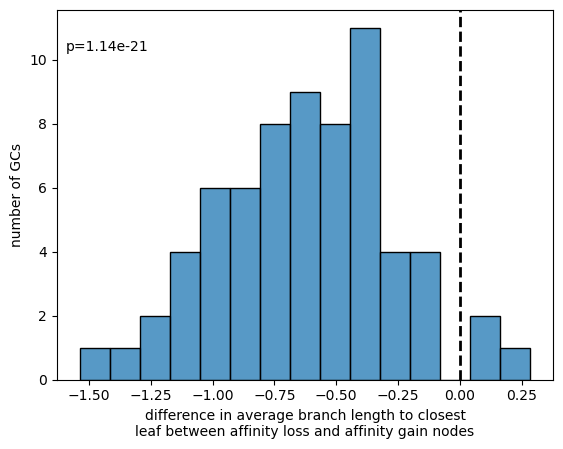

In [22]:
diff_stat = df_groups.query("`affinity change stratum` == 'affinity loss'").set_index("GC").closest_leaf_distance_nt - df_groups.query("`affinity change stratum` == 'affinity gain'").set_index("GC").closest_leaf_distance_nt

from scipy.stats import ttest_1samp

p = ttest_1samp(diff_stat, 0).pvalue

sns.histplot(diff_stat, bins=15)
plt.xlabel("difference in average branch length to closest\nleaf between affinity loss and affinity gain nodes")
plt.ylabel("number of GCs")
plt.axvline(0, c="k", ls="--", lw=2)
plt.annotate(f"p={p:.2e}", (0.1, 0.9), xycoords="axes fraction", va="center", ha="center")
plt.savefig(f"{output_dir}/terrible-significance.pdf")
plt.show()

### Do high REI events drive GC-wise affinity outcomes?

In [23]:
early_burst_GCs = set(df.loc[(df.REI > 0.05) & (df.root_distance_nt <= 2)].GC.unique())
early_burst_GCs

{'mouse1_GC1',
 'mouse1_GC14',
 'mouse1_GC16',
 'mouse1_GC20',
 'mouse1_GC7',
 'mouse2_GC26',
 'mouse2_GC29',
 'mouse2_GC40',
 'mouse3_GC42',
 'mouse3_GC43',
 'mouse3_GC65',
 'mouse4_GC47',
 'mouse4_GC48',
 'mouse4_GC73',
 'mouse5_GC79',
 'mouse5_GC83',
 'mouse6_GC75',
 'mouse6_GC77'}

In [24]:
df["early_burst_GC"] = df.GC.isin(early_burst_GCs)
df

,GC,name,parent_name,aa_mutations,aa_mutations_edge_gained,aa_mutations_edge_lost,abundance,n_mutant_edges,polytomy_degree,LBI,...,delta_bind_CGG_naive,parent_delta_bind_CGG_naive,delta_bind_CGG_edge,delta_expr,delta_psr,affinity stratum,affinity change stratum,divergence stratum,leaf distance stratum,early_burst_GC
0,mouse1_GC1,naive,NaN,,,,0,5,5,11.383587,...,0.00000,NaN,NaN,0.00000,0.00000,affinity neutral,NaN,NaN,"(10.0, 21.0]",True
1,mouse1_GC1,seq62,naive,Y103(H)F;S20(L)N;L116(L)P,S20(L)N;Y103(H)F;L116(L)P,,1,0,1,1.172202,...,-0.06082,0.00000,-0.06082,0.14827,-0.13364,affinity neutral,affinity neutral,"(2.0, 4.0]",NaN,True
2,mouse1_GC1,seq9,naive,E51(H)G;Y52(H)F;Y66(L)N;V71(L)I;D74(L)A;Q95(L)...,D74(L)A;N108(L)K;Y114(L)F;E51(H)G;Y66(L)N;S96(...,,1,0,1,1.000157,...,-3.45668,0.00000,-3.45668,-1.05627,3.34321,affinity loss,affinity loss,"(8.0, 21.0]",NaN,True
3,mouse1_GC1,seq76,naive,Y58(H)D,Y58(H)D,,1,1,2,5.881581,...,-0.80796,0.00000,-0.80796,-0.15104,-0.15010,affinity neutral,affinity neutral,"(0.0, 1.0]","(0.0, 2.0]",True
4,mouse1_GC1,1,naive,N40(H)H;N108(L)D;Y114(L)S;E125(L)Q,Y114(L)S;E125(L)Q;N108(L)D;N40(H)H,,0,2,2,3.115025,...,-7.71074,0.00000,-7.71074,-0.77924,2.61806,affinity loss,affinity loss,"(2.0, 4.0]","(2.0, 5.0]",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5586,mouse6_GC77,seq45,2,K49(H)I;G54(H)V;S70(H)A;K72(H)R;S74(H)G;I78(H)...,Y88(H)S,,1,0,1,1.363245,...,-0.00473,0.01741,-0.02214,-1.97716,4.12977,affinity neutral,affinity neutral,"(8.0, 21.0]",NaN,True
5587,mouse6_GC77,seq19,12,S57(H)N;S64(H)R;T65(H)I;Y103(H)F;A105(H)G,Y103(H)F,,1,0,1,1.072084,...,1.23641,1.19398,0.04243,-0.08653,0.23259,affinity gain,affinity neutral,"(8.0, 21.0]",NaN,True
5588,mouse6_GC77,seq17,12,S57(H)N;S64(H)R;T65(H)I;A105(H)G;M11(L)L;G36(L...,G36(L)V;K123(L)N;M11(L)L;Y66(L)S,,2,0,2,2.273950,...,-0.00518,1.19398,-1.19916,-0.31626,-0.55349,affinity neutral,affinity loss,"(8.0, 21.0]",NaN,True
5589,mouse6_GC77,seq9,12,S57(H)N;S64(H)R;T65(H)I;L89(H)V;A105(H)G,L89(H)V,,3,1,4,4.030638,...,1.08960,1.19398,-0.10438,-0.12466,-0.23740,affinity gain,affinity neutral,"(4.0, 8.0]","(0.0, 2.0]",True


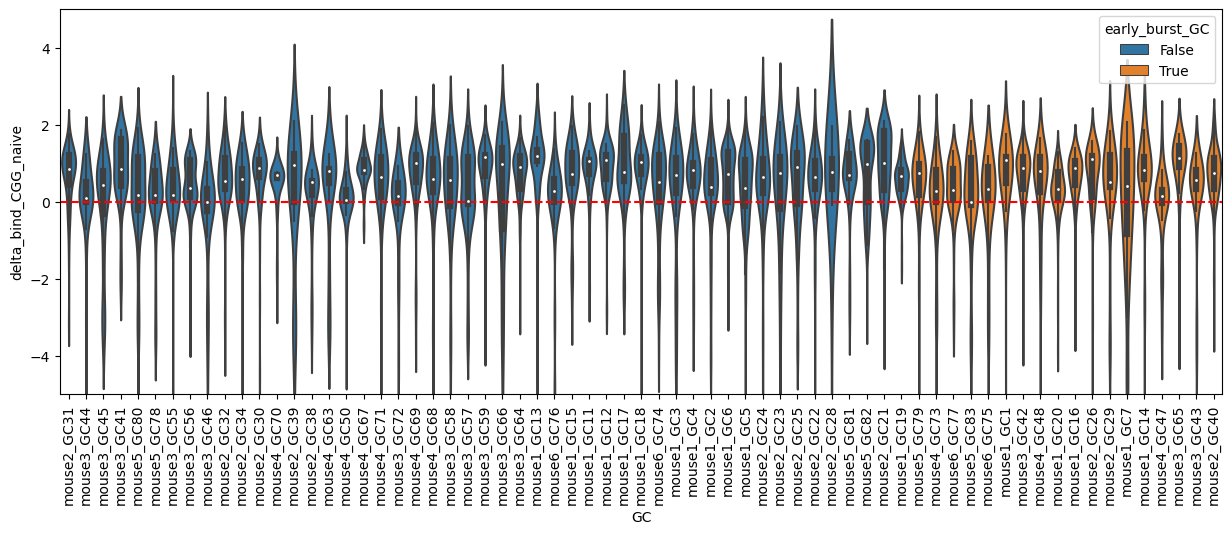

In [25]:
plt.figure(figsize=(15, 5))
sns.violinplot(data=df.sort_values("early_burst_GC"), x="GC", hue="early_burst_GC", y="delta_bind_CGG_naive", weights="abundance", dodge=False)
plt.axhline(0, ls="--", c="red")
plt.ylim(-5, 5)
plt.xticks(rotation=90)
plt.show()

Mutability change Vs affinity change over edges

In [26]:
# g = sns.JointGrid(data=df, x="mutability_change", y="delta_bind_CGG_edge", ylim=(-2, 2), height=10, ratio=3)
# g = g.plot_joint(sns.histplot, bins=(30, 120), vmax=60, cmap="viridis", fill=True)
# sns.histplot(x=df["mutability_change"], bins=30, color="grey", ax=g.ax_marg_x)
# sns.histplot(y=df["delta_bind_CGG_edge"], bins=120, color="grey", ax=g.ax_marg_y)
# plt.show()

In [27]:
# plt.figure(figsize=(4.5, 4.5))
# ax = sns.histplot(data=df, x="mutability_change", hue="affinity change stratum",
#              hue_order=palette.keys(),
#              bins=10,
#              stat="probability", common_norm=False,
#              palette=palette,
#              fill=False, element="poly", linewidth=2)

## Frequent mutations

In [28]:
from collections import Counter

mutation_events = Counter()
mutation_prevalence = Counter()
for idx, row in df.iterrows():
    if row.aa_mutations_edge_gained:
        mutation_events.update(row.aa_mutations_edge_gained.split(";"))
    if row.abundance and row.aa_mutations:
        mutation_prevalence.update({mutation: row.abundance for mutation in row.aa_mutations.split(";")})

In [29]:
df_mutations = pd.Series(mutation_events, name="mutation_events").to_frame().join(pd.Series(mutation_prevalence, name="mutation_prevalence"))
df_mutations.sort_values("mutation_events", ascending=False)[:20]

,mutation_events,mutation_prevalence
S57(H)N,239,681
S64(H)N,163,340
N108(L)K,140,1061
S109(L)N,137,269
Q105(L)H,122,679
E101(L)D,112,169
Y42(L)F,98,345
S109(L)R,97,425
A105(H)G,95,2536
S64(H)T,87,197


### Pairwise epistasis

### Is the bump still there if we remove putatively epistatic mutations or high incidence mutations?

In [30]:
epi_mutations = pd.read_csv("output/mutations/epistatic-pairs.csv")
epi_mutations = set(np.concatenate((epi_mutations["background mutation"].values, epi_mutations["mutation event"].values)))
epi_mutations

{'A105(H)G',
 'E101(L)D',
 'K123(L)N',
 'N108(L)H',
 'N108(L)K',
 'Q105(L)H',
 'S109(L)N',
 'S109(L)R',
 'S109(L)T',
 'S57(H)N',
 'S64(H)N',
 'S64(H)R',
 'T37(L)S',
 'Y42(L)F'}

In [31]:
topn = 30
freq_mutations = df_mutations.sort_values("mutation_events", ascending=False)[:topn].index

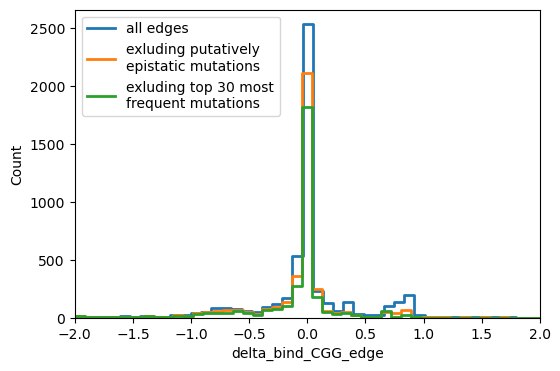

In [32]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df,
             x="delta_bind_CGG_edge",
             bins=150, color="C0",
             label="all edges",
             fill=False, element="step", linewidth=2)
sns.histplot(data=df.loc[df.aa_mutations_edge_gained.map(lambda mutations: not any(mutation in epi_mutations for mutation in mutations.split(";")))],
             x="delta_bind_CGG_edge",
             bins=150, color="C1", 
             label=f"exluding putatively\nepistatic mutations",
             fill=False, element="step", linewidth=2)
sns.histplot(data=df.loc[df.aa_mutations_edge_gained.map(lambda mutations: not any(mutation in freq_mutations for mutation in mutations.split(";")))],
             x="delta_bind_CGG_edge",
             bins=150, color="C2", 
             label=f"exluding top {topn} most\nfrequent mutations",
             fill=False, element="step", linewidth=2)
plt.xlim(-2, 2)
plt.legend(loc="upper left")
plt.savefig(f"{output_dir}/bump.pdf")
plt.show()

## Permissive selection below bursts? Stratified by root distance